In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
from nltk.translate.bleu_score import sentence_bleu

from plots.plots import simple_step_plot

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

Loading data files
==================

The data for this project is a set of many thousands of English to
French translation pairs.

`This question on Open Data Stack
Exchange <http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
pointed me to the open translation site http://tatoeba.org/ which has
downloads available at http://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: http://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.



In [2]:
#! wget https://download.pytorch.org/tutorial/data.zip

In [3]:
# ! unzip data.zip

Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt:





We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [4]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


example = "ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf"
print("Before:", example)
print()
print("After:", normalizeString(example))



Before: ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf

After: ddddda capoeeeeeee ! ! aas fdf


To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [7]:
eng, fra, pairs = readLangs("eng", "fra")

Reading lines...


In [8]:
print(eng.n_words)
print(fra.n_words)
np.random.shuffle(pairs)
for t in pairs[0:10]:
    print(t[0], ">>>>", t[1])
    print(len(t[0].split(' ')), ">>>>", len(t[1].split(' ')))    

2
2
will you have some coffee ? >>>> voulez vous un peu de cafe ?
6 >>>> 7
they hurried to the scene of the accident . >>>> ils se precipiterent sur le lieu de l accident .
9 >>>> 10
once you ve formed a bad habit you can t get rid of it easily . >>>> une fois que tu as une mauvaise habitude tu ne peux pas t en debarrasser facilement .
16 >>>> 17
you should not be afraid of the future . >>>> tu ne devrais pas avoir peur de l avenir !
9 >>>> 10
the royal palace was built on a hill . >>>> le palais royal fut erige sur une colline .
9 >>>> 9
keep your hands to yourself . >>>> gardez vos mains dans les poches !
6 >>>> 7
i thought we could use the cloth napkins . >>>> j ai pense que nous pourrions utiliser les serviettes en tissu .
9 >>>> 12
we have plenty of time tonight . >>>> nous avons tout le temps ce soir .
7 >>>> 8
does this actually make you happy ? >>>> cela vous rend il vraiment heureuses ?
7 >>>> 7
check your pockets . >>>> verifiez vos poches !
4 >>>> 4


Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [9]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [10]:
pairs_rev = [(t[1],t[0]) for t in pairs]

In [11]:
f_pairs = filterPairs(pairs_rev)

In [12]:
for t in f_pairs[0:12]:
    print(t[0], ">>>>", t[1])
    print(len(t[0].split(' ')), ">>>>", len(t[1].split(' ')))    

je suis en train de mediter . >>>> i m meditating .
7 >>>> 4
je suis tatillon . >>>> i m fussy .
4 >>>> 4
nous partons pour hawai ce soir . >>>> we are leaving for hawaii tonight .
7 >>>> 7
je n ai pas peur des fantomes . >>>> i m not afraid of ghosts .
8 >>>> 7
vous etes matinal . >>>> you re early .
4 >>>> 4
il est assis dans la salle d attente . >>>> he s sitting in the waiting room .
9 >>>> 8
nous sommes en couple . >>>> we re a couple .
5 >>>> 5
tu es avec des amies . >>>> you re with friends .
6 >>>> 5
il est en train d y reflechir . >>>> he is thinking it over .
8 >>>> 6
il se rend au concert . >>>> he is going to the concert .
6 >>>> 7
je suis ouvert aux propositions . >>>> i m open to suggestions .
6 >>>> 6
il hume la soupe . >>>> he is smelling the soup .
5 >>>> 6


The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [13]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925


Transforming sentences 2 tensors

In [14]:
example = random.choice(pairs)
print(example)

['vous etes encore en train de grandir .', 'you re still growing .']


In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

In [16]:
indexesFromSentence(input_lang,example[0])

[118, 215, 975, 14, 100, 101, 2533, 5]

In [17]:
indexesFromSentence(output_lang, example[1])

[130, 78, 532, 1480, 4]

In [18]:
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [19]:
input_sen = tensorFromSentence(input_lang,example[0])

print(input_sen)
print()
print(input_sen.shape)
print(input_sen.dtype)

tensor([[ 118],
        [ 215],
        [ 975],
        [  14],
        [ 100],
        [ 101],
        [2533],
        [   5],
        [   1]])

torch.Size([9, 1])
torch.int64


In [20]:
output_sen = tensorFromSentence(output_lang, example[1])

print(output_sen)
print()
print(output_sen.shape)
print(output_sen.dtype)

tensor([[ 130],
        [  78],
        [ 532],
        [1480],
        [   4],
        [   1]])

torch.Size([6, 1])
torch.int64


In [21]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [22]:
input_sen, output_sen = tensorsFromPair(example)


print("input\n")
print(input_sen)
print()
print(input_sen.shape)
print(input_sen.dtype)

print("\noutput\n")
print(output_sen)
print()
print(output_sen.shape)
print(output_sen.dtype)

input

tensor([[ 118],
        [ 215],
        [ 975],
        [  14],
        [ 100],
        [ 101],
        [2533],
        [   5],
        [   1]])

torch.Size([9, 1])
torch.int64

output

tensor([[ 130],
        [  78],
        [ 532],
        [1480],
        [   4],
        [   1]])

torch.Size([6, 1])
torch.int64


## Encoder

In [23]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [24]:
fra_v_size = 4489
eng_v_size = 2925
hidden_size = 10

In [25]:
encoder = EncoderRNN(fra_v_size, hidden_size)
h0 = encoder.initHidden()
print("input_sen:", input_sen.shape, input_sen.dtype)
print("h0:", h0.shape, h0.dtype)

input_sen: torch.Size([9, 1]) torch.int64
h0: torch.Size([1, 1, 10]) torch.float32


In [26]:
max_length = 10
encoder_outputs = torch.zeros(max_length,
                              encoder.hidden_size,
                              device=device)

print(encoder_outputs.shape)

print()

print(encoder_outputs)

print()

input_length = input_sen.size(0)



for ei in range(input_length):
    output, hidden_enc = encoder(input_sen[ei], h0)
    h0 = hidden_enc
    encoder_outputs[ei] = output[0, 0]
    print(output)
    print()

print()
    
print(encoder_outputs.shape)

print()

print(encoder_outputs)

print()


torch.Size([10, 10])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

tensor([[[ 0.2880, -0.1259, -0.4067, -0.1888, -0.1788, -0.1549,  0.2889,
          -0.1882,  0.0694,  0.0259]]], grad_fn=<CatBackward>)

tensor([[[-0.3817, -0.2865, -0.0549, -0.2977, -0.0574,  0.4198, -0.3046,
           0.2976, -0.5758, -0.1762]]], grad_fn=<CatBackward>)

tensor([[[-0.0121, -0.0190, -0.3878, -0.2918, -0.1767,  0.1520, -0.1096,
          -0.1062, -0.0031,  0.0251]]], grad_fn=<CatBackward>)

tensor([[[ 0.1005,  0.0296, -0.5113, -0.6955, -0.3573,  0.2891, -

In [27]:
print("output:", output.shape, output.dtype)
print("hidden_enc:", hidden_enc.shape, hidden_enc.dtype)

output: torch.Size([1, 1, 10]) torch.float32
hidden_enc: torch.Size([1, 1, 10]) torch.float32


## Decoder

In [28]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [29]:
decoder = DecoderRNN(hidden_size, eng_v_size)

decoder_input = torch.tensor([[SOS_token]], device=device)

decoder_hidden = hidden_enc

target_length = output_sen.size(0)

for di in range(target_length):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
    decoder_input = output_sen[di]  # Teacher forcing
    print("decoder_output:", decoder_output.shape, decoder_output.dtype)
    print()
    print("decoder_hidden:", decoder_hidden.shape, decoder_hidden.dtype)    


decoder_output: torch.Size([1, 2925]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 2925]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 2925]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 2925]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 2925]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 2925]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32


## training

In [30]:
learning_rate = 0.2
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

## Calculate loss over each token of the target language

In [31]:
MAX_LENGTH = 10

def train(input_tensor,
          target_tensor,
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          criterion,
          max_length=MAX_LENGTH,
          teacher_forcing_ratio=0.5):

    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length,
                                  encoder.hidden_size,
                                  device=device)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    use_teacher_forcing = True

    if not random.random() < teacher_forcing_ratio:
        use_teacher_forcing = False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            _, topone = decoder_output.topk(1)
            decoder_input = topone.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

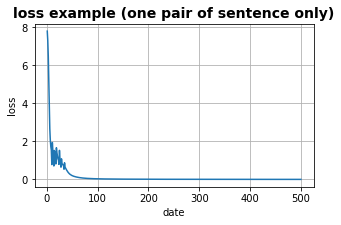

In [32]:
losses = []
for i in range(500):
    loss = train(input_sen,
          output_sen,
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          criterion,
          max_length=MAX_LENGTH)
    losses.append(loss)

simple_step_plot([losses],
                 "loss",
                 "loss example (one pair of sentence only)",
                 "loss_example.png",
                  figsize=(5,3))

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [33]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    return '%s' % asMinutes(s)

In [34]:
start = time.time()

for _ in range(10):
    time.sleep(0.2)

print(timeSince(start))

0m 2s


The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




0m 10s


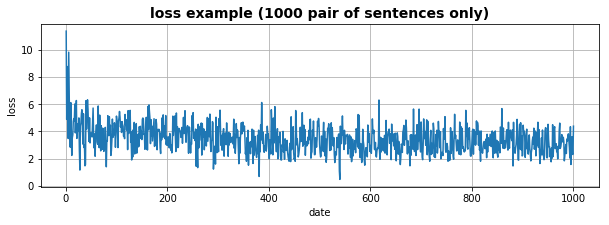

In [35]:
n_iters = 1000
training_pairs = [tensorsFromPair(random.choice(pairs))
                  for i in range(n_iters)]

losses = []
start = time.time()

for t in training_pairs:
    input_sen, output_sen = t    
    loss = train(input_sen,
          output_sen,
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          criterion,
          max_length=MAX_LENGTH)
    losses.append(loss)

print(timeSince(start))

simple_step_plot([losses],
                 "loss",
                 "loss example ({} pair of sentences only)".format(n_iters),
                 "loss_example.png",
                  figsize=(10,3))

In [36]:
def trainIters(encoder,
               decoder,
               n_iters,
               status_every=100,
               learning_rate=0.01,
               teacher_forcing_ratio=0.5):

    plot_losses = []
    old = 0
    start = time.time()
    all_loss = []

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]

    for i, t in enumerate(training_pairs):
        input_sen, output_sen = t
        loss = train(input_sen,
                     output_sen,
                     encoder,
                     decoder,
                     encoder_optimizer,
                     decoder_optimizer,
                     criterion,
                     max_length=MAX_LENGTH,
                     teacher_forcing_ratio=teacher_forcing_ratio)
        plot_losses.append(loss)

        if i % status_every == 0 and i != 0:
            print("mean loss = {:.2f}\n".format(np.mean(plot_losses)))
            print("time in {} steps:".format(status_every), timeSince(start))
            simple_step_plot([plot_losses],
                             "loss",
                             "loss plot (from {} to {})".format(old, i),
                             "loss_example.png",
                             figsize=(10, 3))
            all_loss += plot_losses
            plot_losses = []
            old = i
            start = time.time()
    
    simple_step_plot([all_loss],
                     "loss",
                     "loss over training" ,
                     "loss_example.png",
                     figsize=(15, 3))


## translating

In [37]:
def translate(encoder,
              decoder,
              sentence,
              max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()

        return " ".join(decoded_words)

# translation of an non trained model

In [38]:
encoder = EncoderRNN(fra_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_v_size)

np.random.shuffle(f_pairs)

In [39]:
from nltk.translate.bleu_score import sentence_bleu


for t in f_pairs[0:5]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    print("reference translation : " + t[1])
    reference = t[1].split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu(reference, candidate)
    print("blue score = {:.2f}".format(score))
    print()


input_sentence : je finis mes devoirs .
neural translation : aggressive dance smokes vegetables dance smokes spoiling smokes vegetables dance
reference translation : i m finishing my homework .
blue score = 0.00

input_sentence : il est absent de l ecole .
neural translation : aggressive dance smokes vegetables dance smokes spoiling smokes vegetables dance
reference translation : he is absent from school .
blue score = 0.00

input_sentence : il a deux ans de plus que mary .
neural translation : aggressive dance smokes vegetables dance smokes spoiling smokes vegetables dance
reference translation : he s two years older than mary is .
blue score = 0.00

input_sentence : je suis parfaitement conscient de ce fait .
neural translation : aggressive dance smokes blushing paintings paintings paintings dance bride bjork
reference translation : i m fully aware of that fact .
blue score = 0.00

input_sentence : vous ne m ecoutez pas .
neural translation : aggressive dance mumps smokes vegetables 

# translation of an trained model

mean loss = 5.10

time in 1000 steps: 0m 11s
mean loss = 3.77

time in 1000 steps: 0m 10s
mean loss = 3.52

time in 1000 steps: 0m 9s
mean loss = 3.36

time in 1000 steps: 0m 10s
input_sentence : je finis mes devoirs .
neural translation : you re not . <EOS>
reference translation : i m finishing my homework .
blue score = 0.67

input_sentence : il est absent de l ecole .
neural translation : you re not . <EOS>
reference translation : he is absent from school .
blue score = 0.67

input_sentence : il a deux ans de plus que mary .
neural translation : i m not . <EOS>
reference translation : he s two years older than mary is .
blue score = 0.88

input_sentence : je suis parfaitement conscient de ce fait .
neural translation : you re not . <EOS>
reference translation : i m fully aware of that fact .
blue score = 0.67

input_sentence : vous ne m ecoutez pas .
neural translation : i m not . <EOS>
reference translation : you re not listening to me .
blue score = 0.88



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


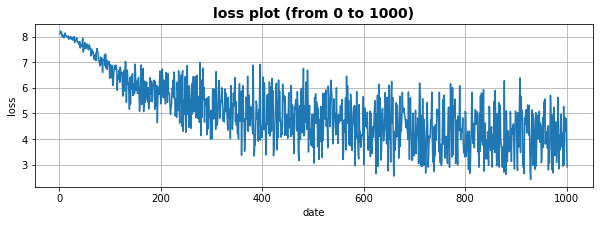

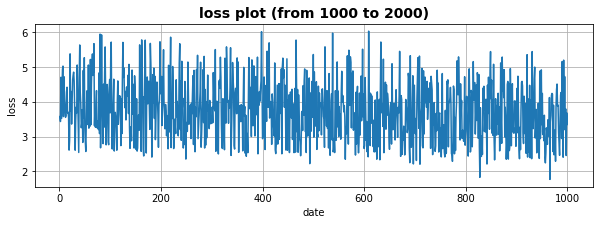

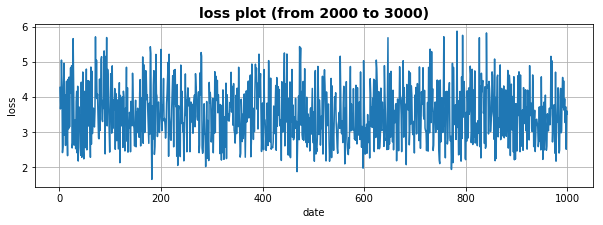

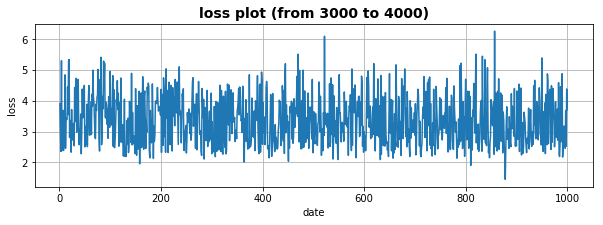

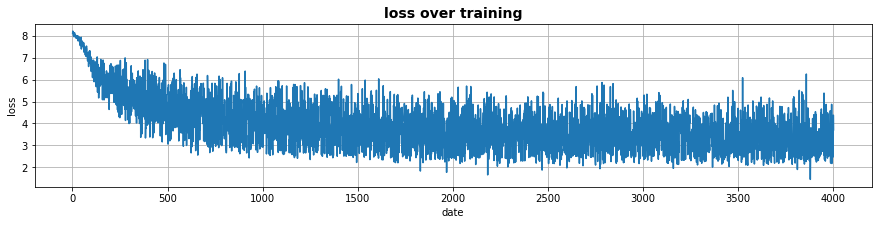

In [40]:
encoder = EncoderRNN(fra_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_v_size)


trainIters(encoder,
           decoder,
           n_iters=5000,
           status_every=1000,
           learning_rate=0.01,
           teacher_forcing_ratio=1)


for t in f_pairs[0:5]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    print("reference translation : " + t[1])
    reference = t[1].split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu(reference, candidate)
    print("blue score = {:.2f}".format(score))
    print()


mean loss = 4.34

time in 1000 steps: 0m 9s
mean loss = 3.53

time in 1000 steps: 0m 10s
mean loss = 3.53

time in 1000 steps: 0m 10s
mean loss = 3.44

time in 1000 steps: 0m 9s
input_sentence : je finis mes devoirs .
neural translation : i m not . . <EOS>
reference translation : i m finishing my homework .
blue score = 0.60

input_sentence : il est absent de l ecole .
neural translation : i m not . . <EOS>
reference translation : he is absent from school .
blue score = 0.84

input_sentence : il a deux ans de plus que mary .
neural translation : i m not . . <EOS>
reference translation : he s two years older than mary is .
blue score = 0.84

input_sentence : je suis parfaitement conscient de ce fait .
neural translation : i m not . . <EOS>
reference translation : i m fully aware of that fact .
blue score = 0.84

input_sentence : vous ne m ecoutez pas .
neural translation : i m not . . <EOS>
reference translation : you re not listening to me .
blue score = 0.84



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


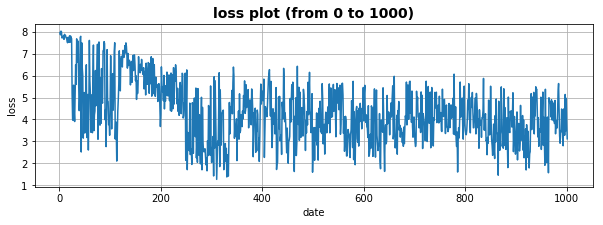

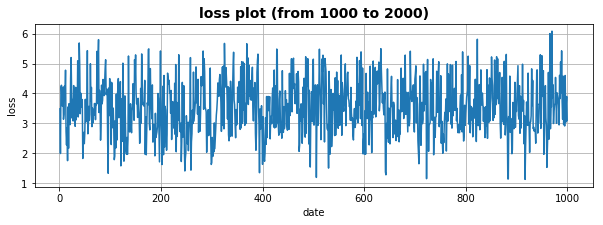

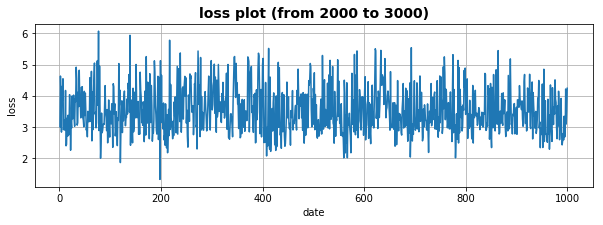

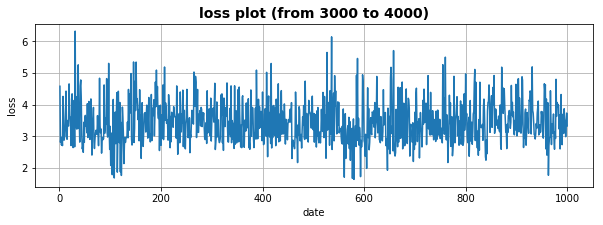

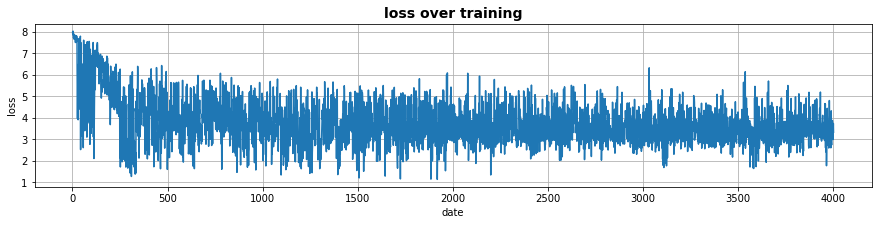

In [41]:
encoder = EncoderRNN(fra_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_v_size)


trainIters(encoder,
           decoder,
           n_iters=5000,
           status_every=1000,
           learning_rate=0.01,
           teacher_forcing_ratio=0.2)


for t in f_pairs[0:5]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    print("reference translation : " + t[1])
    reference = t[1].split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu(reference, candidate)
    print("blue score = {:.2f}".format(score))
    print()
